In [1]:
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
import joblib

import pandas as pd
import numpy as np
import seaborn as sns
import missingno
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import zscore

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/dsrscientist/DSData/master/loan_prediction.csv")
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


# Exploratory Data Analysis (EDA)

In [5]:
df.nunique().to_frame("Unique Values")

#finding unique values to drop the unncessary columns

,Unique Values
Loan_ID,614
Gender,2
Married,2
Dependents,4
Education,2
Self_Employed,2
ApplicantIncome,505
CoapplicantIncome,287
LoanAmount,203
Loan_Amount_Term,10


In [6]:
df.drop("Loan_ID", axis=1, inplace=True)

#dropping the Loan_ID since all 614 rows have unique values which is not going to help in building the Model.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


In [8]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [9]:
# getting list of object data type column names
object_datatype = []
for x in df.dtypes.index:
    if df.dtypes[x] == 'object':
        object_datatype.append(x)
print(f"Object Data Type Columns are:\n", object_datatype)


# getting the list of float data type column names
number_datatype = []
for x in df.dtypes.index:
    if df.dtypes[x] == 'float64' or df.dtypes[x] == 'int64':
        number_datatype.append(x)
print(f"\nNumber Data Type Columns are:\n", number_datatype)

Object Data Type Columns are:
 ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']

Number Data Type Columns are:
 ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


In [11]:
df.isna().sum()

#finding the details of missing data in columns

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [12]:
print(f"Rows and Columns before dropping duplicates: ", df.shape)
df.drop_duplicates(inplace=True)
print(f"Rows and Columns after dropping duplicates: ", df.shape)

#dropping the duplicates to get rid of big datasets.
#below results shows no duplicates

Rows and Columns before dropping duplicates:  (614, 12)
Rows and Columns after dropping duplicates:  (614, 12)


In [14]:
for col in object_datatype:
    print(col)
    print(df[col].value_counts())
    print("="*120)
    
#checking for the unique values in object column.

Gender
Male      489
Female    112
Name: Gender, dtype: int64
Married
Yes    398
No     213
Name: Married, dtype: int64
Dependents
0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64
Education
Graduate        480
Not Graduate    134
Name: Education, dtype: int64
Self_Employed
No     500
Yes     82
Name: Self_Employed, dtype: int64
Property_Area
Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64
Loan_Status
Y    422
N    192
Name: Loan_Status, dtype: int64


# Updating the missing values and treating them with mean and mode

In [15]:
# filling continous data columns with the mean value of that column
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].mean())
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mean())

# filling categorical data columns with the mode value of that column
df['Credit_History']=df['Credit_History'].fillna(df['Credit_History'].mode()[0])
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df['Married'] = df['Married'].fillna(df['Married'].mode()[0])
df['Dependents'] = df['Dependents'].fillna(df['Dependents'].mode()[0])
df['Self_Employed'] = df['Self_Employed'].fillna(df['Self_Employed'].mode()[0])

In [16]:
df.isnull().sum()

#checking for the null values after updating
#below results shows there are no null values

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

# Visualizing the Data

In [17]:
print(f"Object Data Type Column Names: \n", object_datatype)
print(f"\nNumeric Data Type Column Names: \n", number_datatype)

#checking and updating the coulmn types

Object Data Type Column Names: 
 ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']

Numeric Data Type Column Names: 
 ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


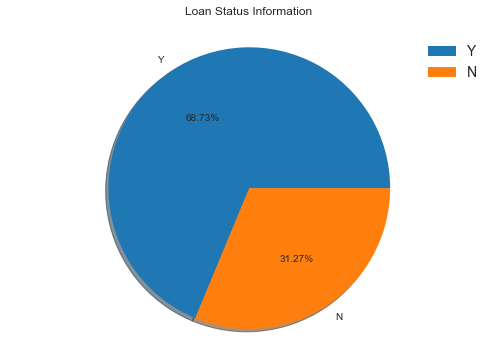

In [18]:
plt.style.use('seaborn-white')
plt.figure(figsize=(7,5))
plt.pie(df['Loan_Status'].value_counts(), labels=df['Loan_Status'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Loan Status Information\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

#below piechart shows the loan status and it shows the Data Imbalance which needs to be treated.

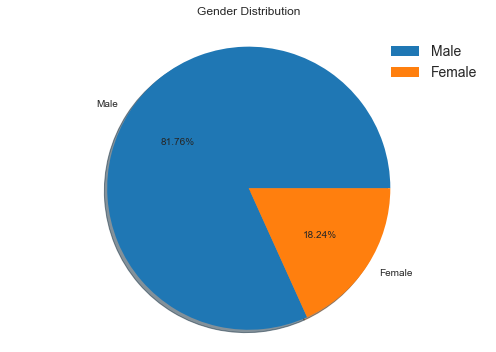

In [19]:
plt.figure(figsize=(7,5))
plt.pie(df['Gender'].value_counts(), labels=df['Gender'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Gender Distribution\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

#below chart shows the loan sharing of males 81.76% while females cover only 18.24% of rows.

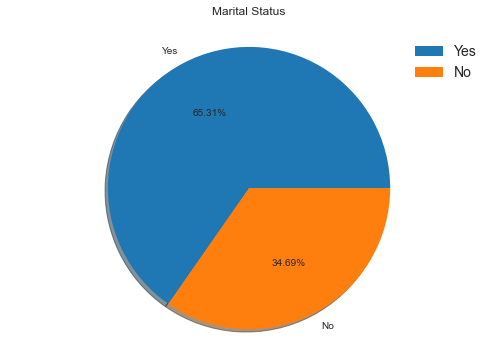

In [20]:
plt.figure(figsize=(7,5))
plt.pie(df['Married'].value_counts(), labels=df['Married'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Marital Status\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

#below chart shows the loan share as per the martial status

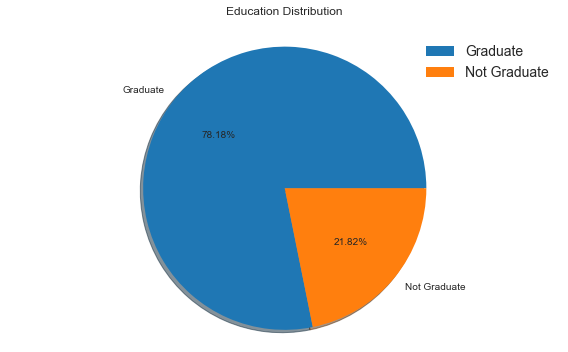

In [21]:
plt.figure(figsize=(8,5))
plt.pie(df['Education'].value_counts(), labels=df['Education'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Education Distribution\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

#below charts shows the Graduation wise loan shares

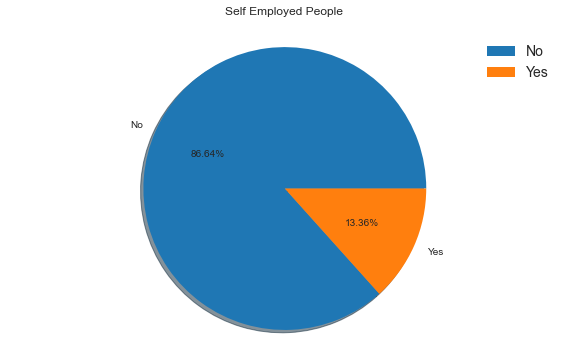

In [22]:
plt.figure(figsize=(8,5))
plt.pie(df['Self_Employed'].value_counts(), labels=df['Self_Employed'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Self Employed People\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

#below charts shows the self employed wise loan shares

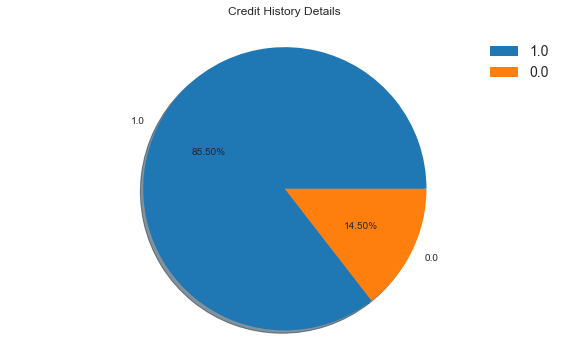

In [23]:
plt.figure(figsize=(8,5))
plt.pie(df['Credit_History'].value_counts(), labels=df['Credit_History'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Credit History Details\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

#below charts shows the loan request has credit history in which 85.50% requests have credit history and rest 14.50% do not have credit history.

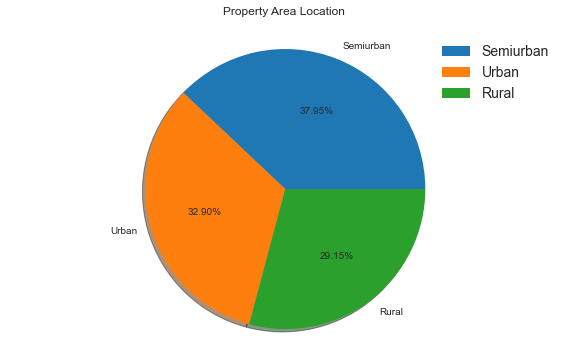

In [24]:
plt.figure(figsize=(8,5))
plt.pie(df['Property_Area'].value_counts(), labels=df['Property_Area'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Property Area Location\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

#location wise loan shares in the below chart

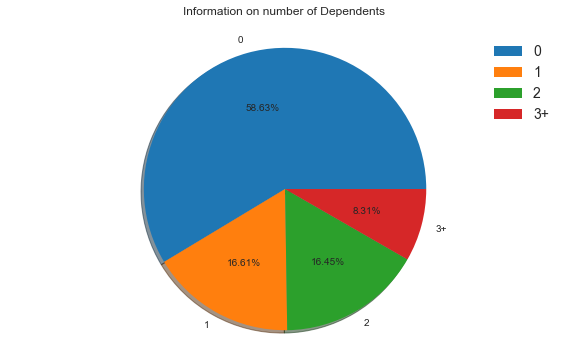

In [25]:
plt.figure(figsize=(8,5))
plt.pie(df['Dependents'].value_counts(), labels=df['Dependents'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Information on number of Dependents\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

#below charts shows the dependent(s) details.

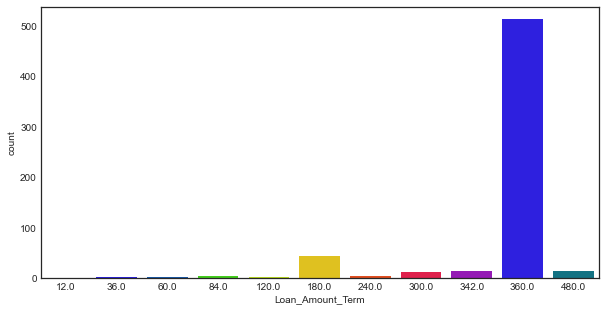

In [26]:
try:
    plt.figure(figsize=(10,5))
    col_name = 'Loan_Amount_Term'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name], palette="prism")
    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    pass

#the below count plot we can see that the highest number of rows are covered by the value 360.0 in the "Loan_Amount_Term" column.

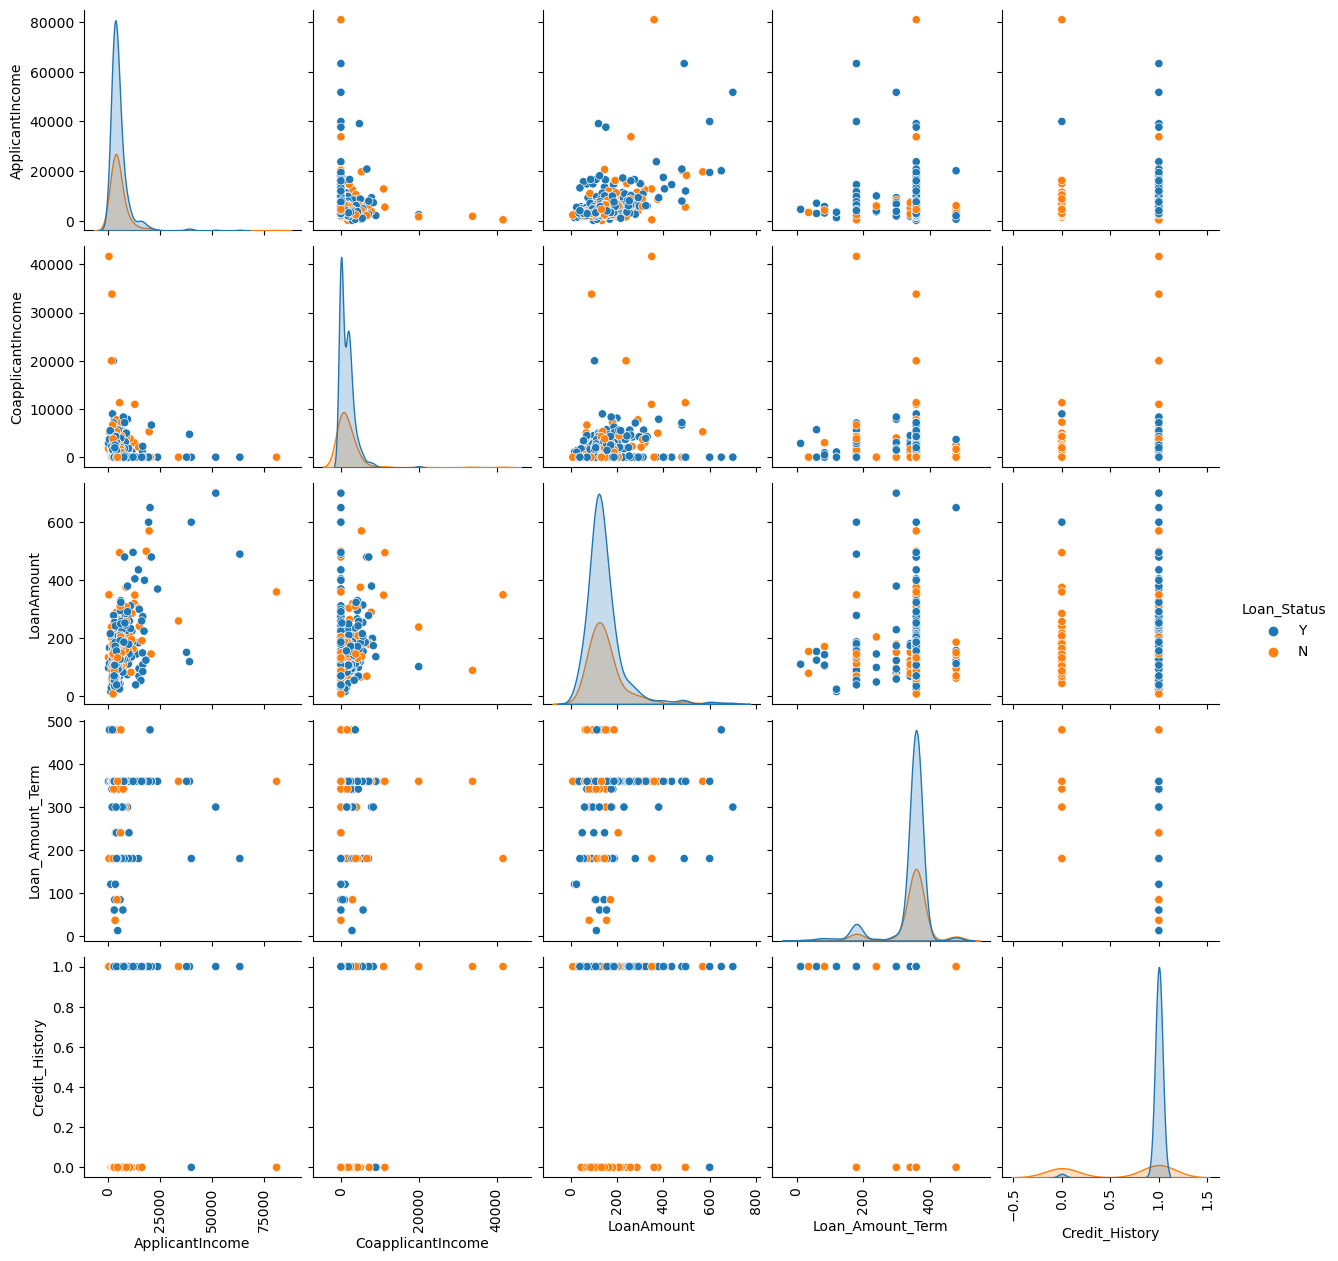

In [27]:
plt.style.use('default')
g = sns.pairplot(df, hue='Loan_Status', diag_kind='kde')
for ax in g.axes.flat:
    ax.tick_params("x", labelrotation=90)
plt.show()

#have generated the above pairplot for our continous data columns that shows us how the data points are distributed in each of the numeric datatype columns.

<AxesSubplot:xlabel='LoanAmount', ylabel='Loan_Amount_Term'>

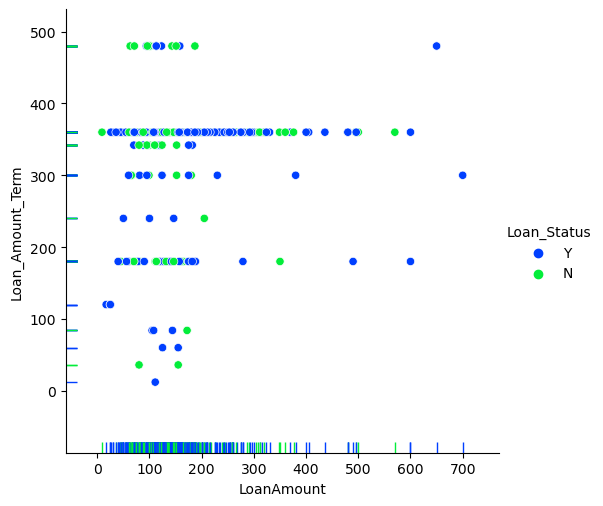

In [28]:
plt.style.use('seaborn-bright')
sns.relplot(data=df, x='LoanAmount', y='Loan_Amount_Term', hue='Loan_Status')
sns.rugplot(data=df, x='LoanAmount', y='Loan_Amount_Term', hue='Loan_Status', legend=False)

#the below plot loan amount vs loan amount term plot we can see that most of the data points are accumulated for 180, 300, 340, 360 and 480 terms while loan amount ranging from 50-250 for a term of 480 mostly seems to be getting rejected than approved.

<AxesSubplot:xlabel='LoanAmount', ylabel='Loan_Amount_Term'>

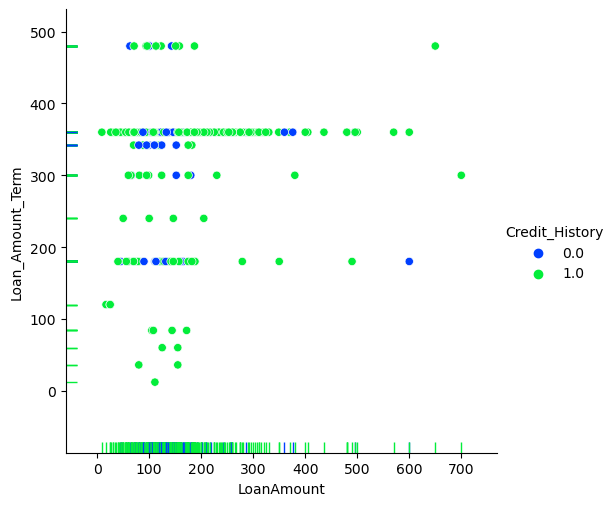

In [29]:
sns.relplot(data=df, x='LoanAmount', y='Loan_Amount_Term', hue='Credit_History')
sns.rugplot(data=df, x='LoanAmount', y='Loan_Amount_Term', hue='Credit_History', legend=False)

#the below plot we can see that in loan amount vs loan amount term datapoints most of the values already have a credit history to showcase.

<AxesSubplot:xlabel='LoanAmount', ylabel='ApplicantIncome'>

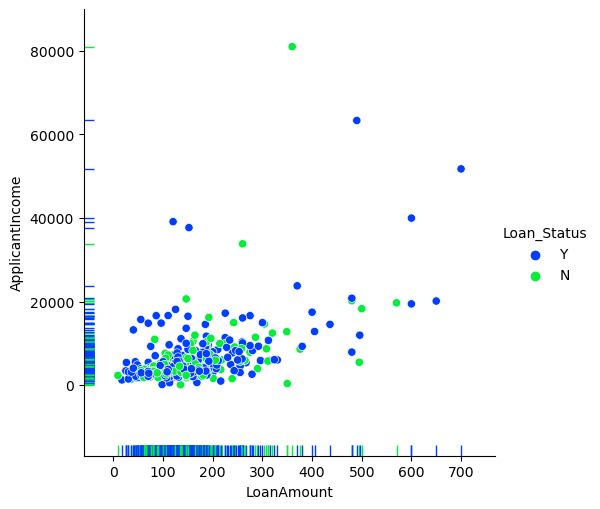

In [30]:
sns.relplot(data=df, x='LoanAmount', y='ApplicantIncome', hue='Loan_Status')
sns.rugplot(data=df, x='LoanAmount', y='ApplicantIncome', hue='Loan_Status', legend=False)

#the below plot we can see that most of the data points are converged near the range 0-20000 data for Applicant Income for mostly loan amount between 0-400

<AxesSubplot:xlabel='LoanAmount', ylabel='ApplicantIncome'>

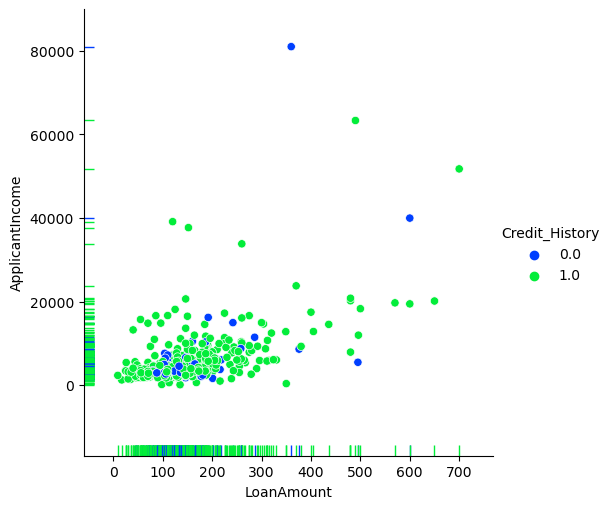

In [31]:
sns.relplot(data=df, x='LoanAmount', y='ApplicantIncome', hue='Credit_History')
sns.rugplot(data=df, x='LoanAmount', y='ApplicantIncome', hue='Credit_History', legend=False)

#the below plot we see that most of the data points have their credit history available and the values are converged between 0-20000 for applicant income and 0-400 for loan amount data

<AxesSubplot:xlabel='LoanAmount', ylabel='CoapplicantIncome'>

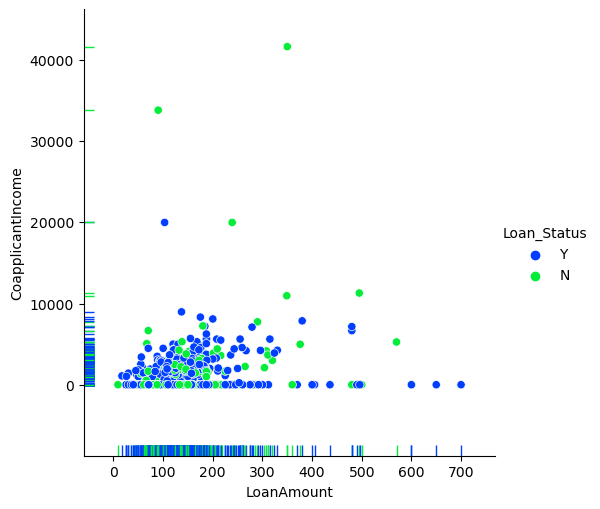

In [32]:
sns.relplot(data=df, x='LoanAmount', y='CoapplicantIncome', hue='Loan_Status')
sns.rugplot(data=df, x='LoanAmount', y='CoapplicantIncome', hue='Loan_Status', legend=False)

#the below plot we see the co applicant income vs loan amount data points where in co applicants with higher income are mostly denied loan where most data values are converged between 0-10000 for co applicant income and 0-300 for loan amount data

<AxesSubplot:xlabel='LoanAmount', ylabel='CoapplicantIncome'>

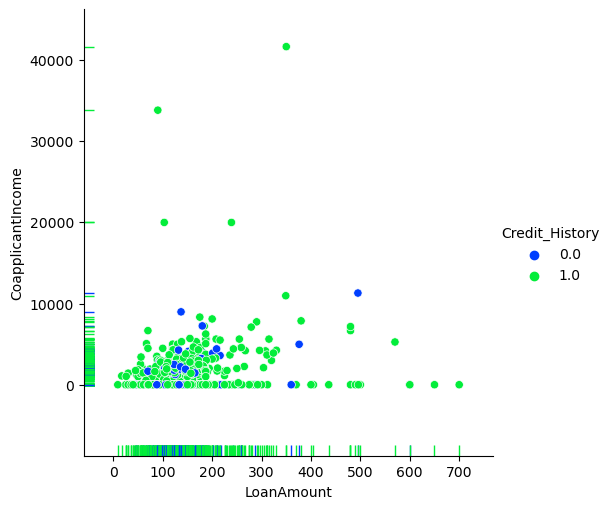

In [33]:
sns.relplot(data=df, x='LoanAmount', y='CoapplicantIncome', hue='Credit_History')
sns.rugplot(data=df, x='LoanAmount', y='CoapplicantIncome', hue='Credit_History', legend=False)

#the below plot we can see that most of the data points are accumulated between 0-10000 for co applicant income and 0-350 for loan amount data and most of these data points have a credit history available for them

# Encoding the categorical object datatype columns

In [34]:
# Label Encoder

le = LabelEncoder()
df["Loan_Status"] = le.fit_transform(df["Loan_Status"])
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,1
1,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,0
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,1
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,1
4,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,1


In [35]:
# Ordinal Encoder

oe = OrdinalEncoder()
df['Gender'] = oe.fit_transform(df['Gender'].values.reshape(-1,1))
df['Married'] = oe.fit_transform(df['Married'].values.reshape(-1,1))
df['Dependents'] = oe.fit_transform(df['Dependents'].values.reshape(-1,1))
df['Education'] = oe.fit_transform(df['Education'].values.reshape(-1,1))
df['Self_Employed'] = oe.fit_transform(df['Self_Employed'].values.reshape(-1,1))
df['Property_Area'] = oe.fit_transform(df['Property_Area'].values.reshape(-1,1))
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1.0,0.0,0.0,0.0,0.0,5849,0.0,146.412162,360.0,1.0,2.0,1
1,1.0,1.0,1.0,0.0,0.0,4583,1508.0,128.000000,360.0,1.0,0.0,0
2,1.0,1.0,0.0,0.0,1.0,3000,0.0,66.000000,360.0,1.0,2.0,1
3,1.0,1.0,0.0,1.0,0.0,2583,2358.0,120.000000,360.0,1.0,2.0,1
4,1.0,0.0,0.0,0.0,0.0,6000,0.0,141.000000,360.0,1.0,2.0,1


In [36]:
print(f"Shape of data frame post encoding is", df.shape)
df.isna().sum()

Shape of data frame post encoding is (614, 12)


Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

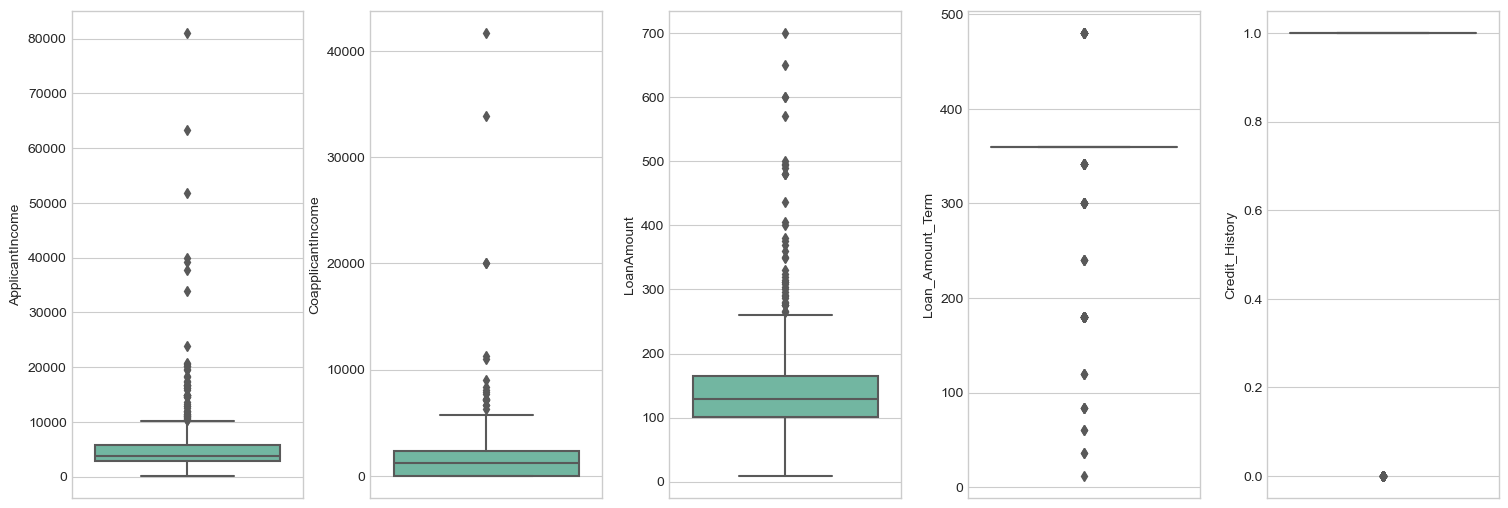

In [37]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(15,5))
index = 0
ax = ax.flatten()
for col, value in df[number_datatype].items():
    sns.boxplot(y=col, data=df, ax=ax[index], palette="Set2")
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()

#the below box plot shows the outlier details present in our numerical data columns which will need to be treated.

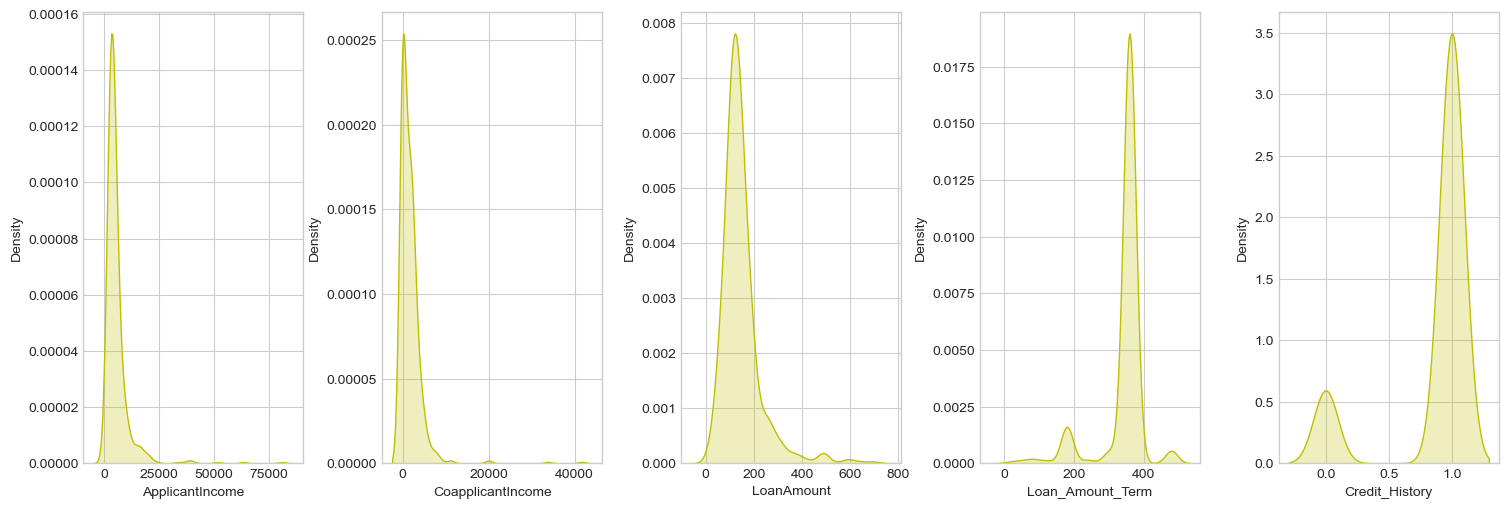

In [38]:
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(15,5))
index = 0
ax = ax.flatten()
for col, value in df[number_datatype].items():
    sns.distplot(value, ax=ax[index], hist=False, color="y", kde_kws={"shade": True})
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()

#the below distribution plot shows the skewness details present in our numerical data columns which will need to be treated.

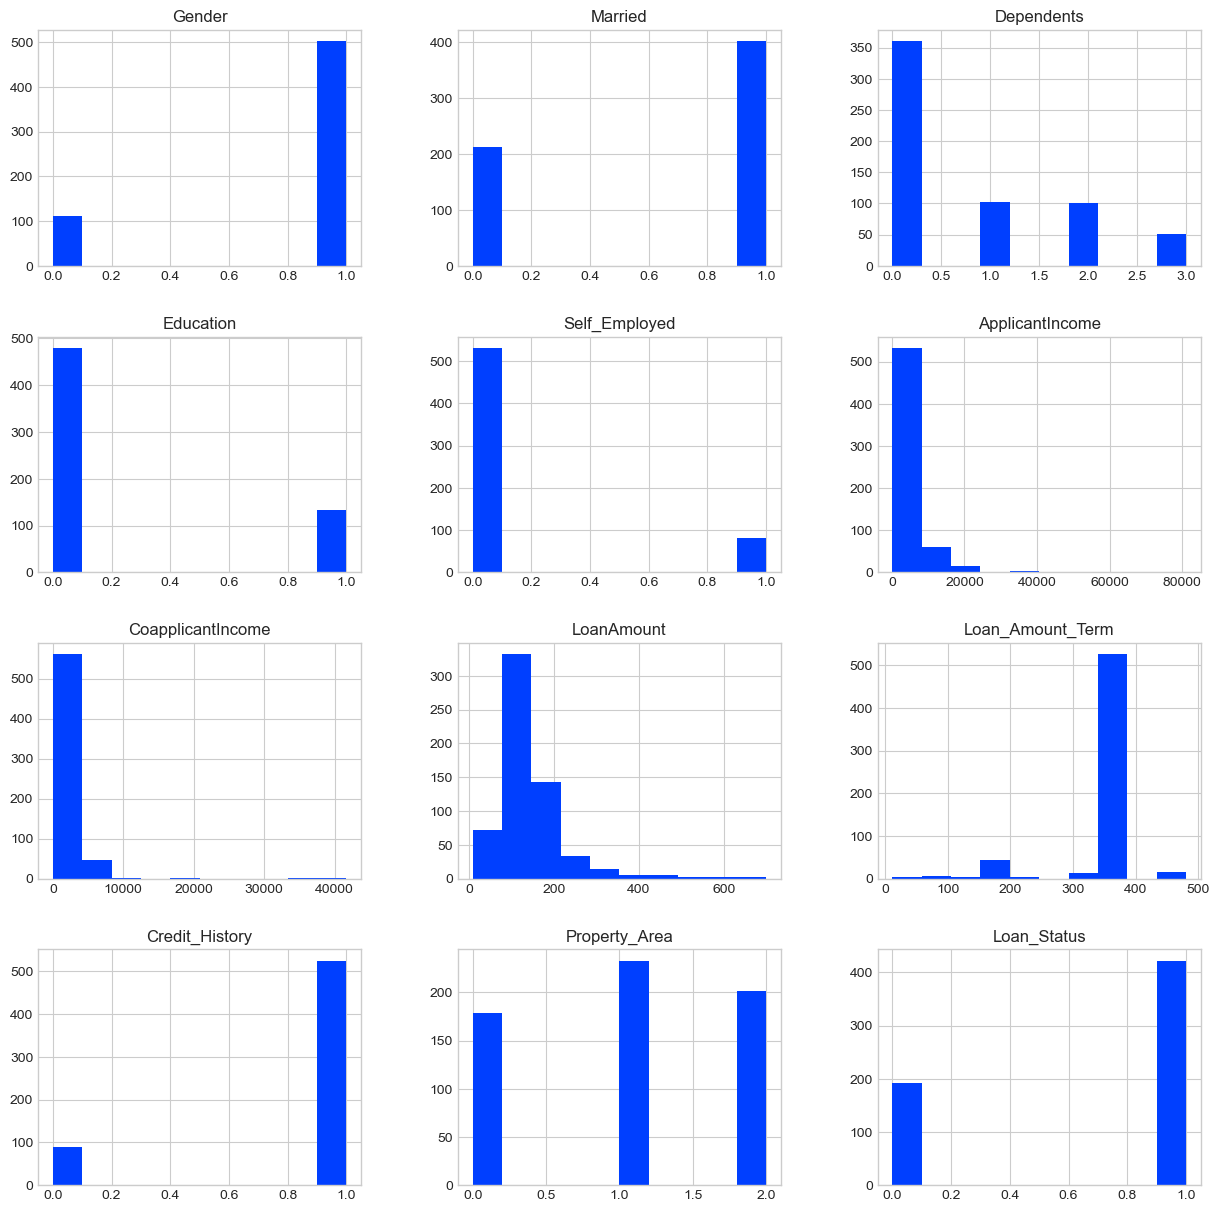

In [39]:
df.hist(figsize=(15,15))
plt.show()

#have generated a histogram for all our dataset columns after applying enconding and converting object datatype to numeric datatype values.

# Correlation using a Heatmap

#Positive correlation - A correlation of +1 indicates a perfect positive correlation, meaning that both variables move in the same direction together.
#Negative correlation - A correlation of –1 indicates a perfect negative correlation, meaning that as one variable goes up, the other goes down.

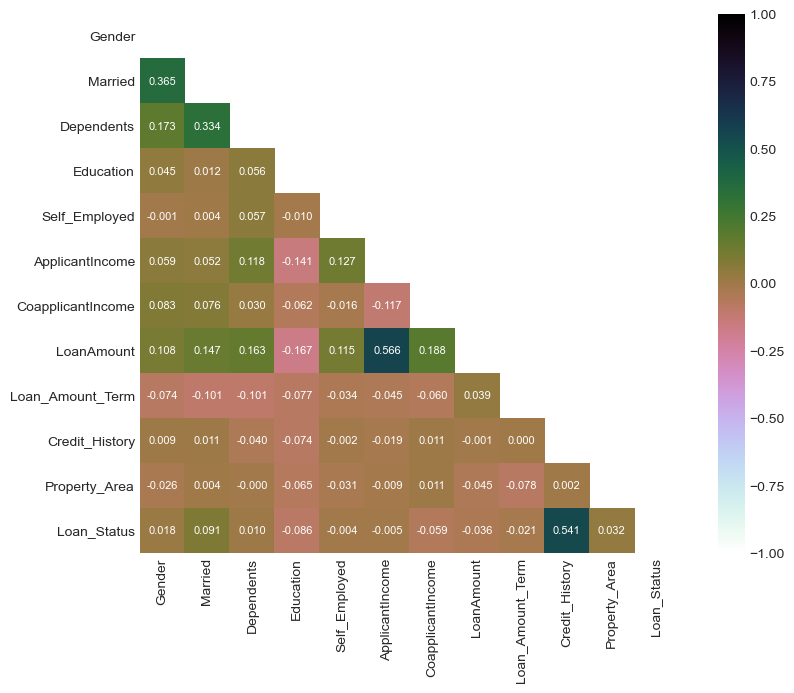

In [40]:
plt.style.use('seaborn-pastel')
upper_triangle = np.triu(df.corr())
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, square=True, fmt='0.3f', 
            annot_kws={'size':8}, cmap="cubehelix_r", mask=upper_triangle)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

#the below heatmap we can see the correlation details plus we can determine that there is no multi collinearity issue between our columns.

# Correlation Bar Plot comparing features with our label

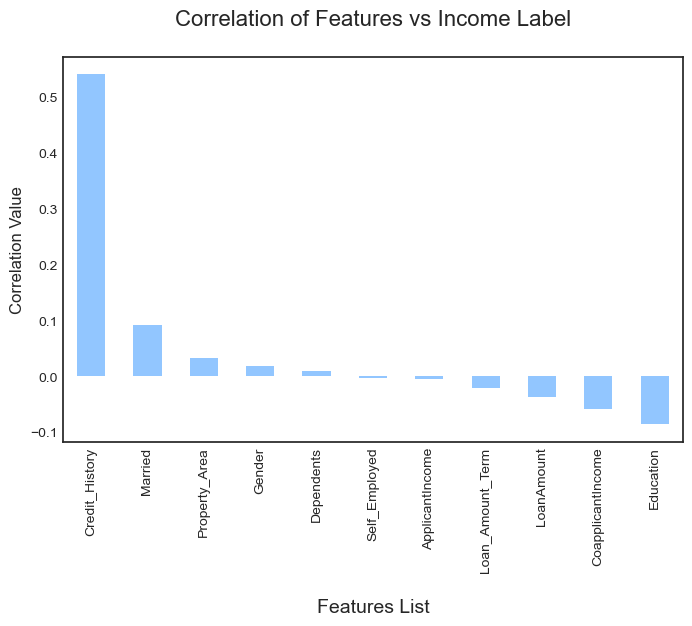

In [41]:
plt.style.use('seaborn-white')
df_corr = df.corr()
plt.figure(figsize=(8,5))
df_corr['Loan_Status'].sort_values(ascending=False).drop('Loan_Status').plot.bar()
plt.title("Correlation of Features vs Income Label\n", fontsize=16)
plt.xlabel("\nFeatures List", fontsize=14)
plt.ylabel("Correlation Value", fontsize=12)
plt.show()

# To Remove Outliers Using Z Score

In [42]:
z = np.abs(zscore(df))
threshold = 3
df1 = df[(z<3).all(axis = 1)]

print ("Shape of the dataframe before removing outliers: ", df.shape)
print ("Shape of the dataframe after removing outliers: ", df1.shape)
print ("Percentage of data loss post outlier removal: ", (df.shape[0]-df1.shape[0])/df.shape[0]*100)

df=df1.copy() # reassigning the changed dataframe name to our original dataframe name

Shape of the dataframe before removing outliers:  (614, 12)
Shape of the dataframe after removing outliers:  (577, 12)
Percentage of data loss post outlier removal:  6.026058631921824


In [43]:
df.skew()

#checking skewness in the data
#below results shows there is a skewness present in our dataset above accepatable range of +/-0.5

Gender              -1.622920
Married             -0.630211
Dependents           1.052106
Education            1.306588
Self_Employed        2.252848
ApplicantIncome      2.148522
CoapplicantIncome    1.350517
LoanAmount           1.113132
Loan_Amount_Term    -2.077031
Credit_History      -1.976043
Property_Area       -0.055332
Loan_Status         -0.822635
dtype: float64

# To Fix Skewness Using Log Transform

In [44]:
for col in number_datatype:
    if df.skew().loc[col]>0.55:
        df[col]=np.log1p(df[col])

In [45]:
df.skew() #checking for the skewness after fixing it

Gender              -1.622920
Married             -0.630211
Dependents           1.052106
Education            1.306588
Self_Employed        2.252848
ApplicantIncome     -0.204913
CoapplicantIncome   -0.216757
LoanAmount          -0.697883
Loan_Amount_Term    -2.077031
Credit_History      -1.976043
Property_Area       -0.055332
Loan_Status         -0.822635
dtype: float64

# Splitting the dataset into 2 variables namely 'X' and 'Y' for feature and label

In [46]:
X = df.drop('Loan_Status', axis=1)
Y = df['Loan_Status']

# Resolving the class imbalance issue in our label column

In [47]:
Y.value_counts()

1    398
0    179
Name: Loan_Status, dtype: int64

In [48]:
# adding samples to make all the categorical label values same

oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

In [49]:
Y.value_counts()

0    398
1    398
Name: Loan_Status, dtype: int64

# Feature Scaling

In [50]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,0.497613,-1.322034,-0.721887,-0.568791,-0.384677,0.733444,-1.088421,0.395684,0.209734,0.556922,1.257686
1,0.497613,0.791700,0.312950,-0.568791,-0.384677,0.271828,0.815378,0.067224,0.209734,0.556922,-1.261718
2,0.497613,0.791700,-0.721887,-0.568791,2.796493,-0.530047,-1.088421,-1.545578,0.209734,0.556922,1.257686
3,0.497613,0.791700,-0.721887,1.860272,-0.384677,-0.813235,0.931592,-0.090387,0.209734,0.556922,1.257686
4,0.497613,-1.322034,-0.721887,-0.568791,-0.384677,0.781683,-1.088421,0.303597,0.209734,0.556922,1.257686


# Finding best random state for building Classification Models

In [51]:
maxAccu=0
maxRS=0

for i in range(1, 1000):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=i)
    lr=LogisticRegression()
    lr.fit(X_train, Y_train)
    pred = lr.predict(X_test)
    acc_score = (accuracy_score(Y_test, pred))*100
    
    if acc_score>maxAccu:
        maxAccu=acc_score
        maxRS=i

print("Best accuracy score is", maxAccu,"on Random State", maxRS)

Best accuracy score is 80.90452261306532 on Random State 728


# Feature importance bar graph

,Importance
Features,
Credit_History,0.249
ApplicantIncome,0.167
LoanAmount,0.159
CoapplicantIncome,0.116
Property_Area,0.083
Dependents,0.060
Education,0.049
Married,0.040
Loan_Amount_Term,0.030


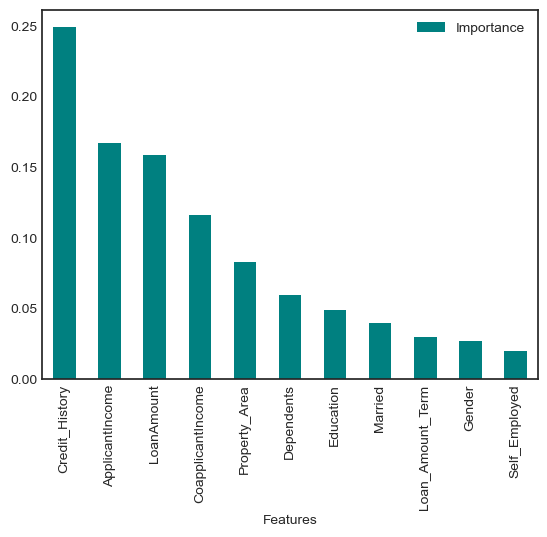

In [52]:
rf=RandomForestClassifier()
rf.fit(X_train, Y_train)
importances = pd.DataFrame({'Features':X.columns, 'Importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('Importance', ascending=False).set_index('Features')
importances.plot.bar(color='teal')
importances

# Machine Learning Model for Classification with Evaluation Metrics

In [53]:
# Classification Model Function

def classify(model, X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=112)
    
    # Training the model
    model.fit(X_train, Y_train)
    
    # Predicting Y_test
    pred = model.predict(X_test)
    
    # Classification Report
    class_report = classification_report(Y_test, pred)
    print("\nClassification Report:\n", class_report)
    
    # Accuracy Score
    acc_score = (accuracy_score(Y_test, pred))*100
    print("Accuracy Score:", acc_score)
    
    # Cross Validation Score
    cv_score = (cross_val_score(model, X, Y, cv=5).mean())*100
    print("Cross Validation Score:", cv_score)
    
    # Result of accuracy minus cv scores
    result = acc_score - cv_score
    print("\nAccuracy Score - Cross Validation Score is", result)

In [54]:
# Logistic Regression

model=LogisticRegression()
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.55      0.68        89
           1       0.72      0.94      0.81       110

    accuracy                           0.76       199
   macro avg       0.80      0.74      0.75       199
weighted avg       0.79      0.76      0.75       199

Accuracy Score: 76.38190954773869
Cross Validation Score: 72.99371069182389

Accuracy Score - Cross Validation Score is 3.388198855914794


In [55]:
# Support Vector Classifier

model=SVC(C=1.0, kernel='rbf', gamma='auto', random_state=42)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.64      0.72        89
           1       0.75      0.89      0.82       110

    accuracy                           0.78       199
   macro avg       0.79      0.77      0.77       199
weighted avg       0.79      0.78      0.77       199

Accuracy Score: 77.88944723618091
Cross Validation Score: 75.12971698113208

Accuracy Score - Cross Validation Score is 2.7597302550488365


In [56]:
# Decision Tree Classifier

model=DecisionTreeClassifier(random_state=21, max_depth=15)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.80      0.76        89
           1       0.82      0.76      0.79       110

    accuracy                           0.78       199
   macro avg       0.78      0.78      0.78       199
weighted avg       0.78      0.78      0.78       199

Accuracy Score: 77.88944723618091
Cross Validation Score: 76.39150943396227

Accuracy Score - Cross Validation Score is 1.4979378022186438


In [57]:
# Random Forest Classifier

model=RandomForestClassifier(max_depth=15, random_state=111)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.79      0.85        89
           1       0.85      0.95      0.89       110

    accuracy                           0.87       199
   macro avg       0.88      0.87      0.87       199
weighted avg       0.88      0.87      0.87       199

Accuracy Score: 87.43718592964824
Cross Validation Score: 82.42059748427673

Accuracy Score - Cross Validation Score is 5.016588445371511


In [58]:
# K Neighbors Classifier

model=KNeighborsClassifier(n_neighbors=15)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.72      0.74        89
           1       0.78      0.82      0.80       110

    accuracy                           0.77       199
   macro avg       0.77      0.77      0.77       199
weighted avg       0.77      0.77      0.77       199

Accuracy Score: 77.38693467336684
Cross Validation Score: 72.36399371069183

Accuracy Score - Cross Validation Score is 5.022940962675008


In [59]:
# Extra Trees Classifier

model=ExtraTreesClassifier()
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.83      0.87        89
           1       0.87      0.93      0.90       110

    accuracy                           0.88       199
   macro avg       0.89      0.88      0.88       199
weighted avg       0.89      0.88      0.88       199

Accuracy Score: 88.44221105527639
Cross Validation Score: 85.562106918239

Accuracy Score - Cross Validation Score is 2.8801041370373923


In [60]:
# XGB Classifier

model=xgb.XGBClassifier(verbosity=0)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82        89
           1       0.85      0.85      0.85       110

    accuracy                           0.84       199
   macro avg       0.84      0.84      0.84       199
weighted avg       0.84      0.84      0.84       199

Accuracy Score: 83.91959798994975
Cross Validation Score: 79.40959119496856

Accuracy Score - Cross Validation Score is 4.510006794981194


In [61]:
# LGBM Classifier

model=lgb.LGBMClassifier()
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.81      0.83        89
           1       0.85      0.89      0.87       110

    accuracy                           0.85       199
   macro avg       0.85      0.85      0.85       199
weighted avg       0.85      0.85      0.85       199

Accuracy Score: 85.42713567839196
Cross Validation Score: 79.91037735849056

Accuracy Score - Cross Validation Score is 5.516758319901399


# Hyper parameter tuning on the best Classification ML Model

In [62]:
# Choosing Extra Trees Classifier

fmod_param = {'criterion' : ['gini', 'entropy'],
              'n_jobs' : [-2, -1, 1],
              'random_state' : [42, 739, 1000],
              'max_depth' : [0, 15, 30],
              'n_estimators' : [100, 200, 300]
             }

In [63]:
GSCV = GridSearchCV(ExtraTreesClassifier(), fmod_param, cv=5)

In [64]:
GSCV.fit(X_train,Y_train)

GridSearchCV(cv=5, estimator=ExtraTreesClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [0, 15, 30],
                         'n_estimators': [100, 200, 300], 'n_jobs': [-2, -1, 1],
                         'random_state': [42, 739, 1000]})

In [65]:
GSCV.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'n_estimators': 100,
 'n_jobs': -2,
 'random_state': 1000}

In [66]:
Final_Model = ExtraTreesClassifier(criterion='entropy', max_depth=30, n_estimators=100, n_jobs=-2, random_state=1000)
Classifier = Final_Model.fit(X_train, Y_train)
fmod_pred = Final_Model.predict(X_test)
fmod_acc = (accuracy_score(Y_test, fmod_pred))*100
print("Accuracy score for the Best Model is:", fmod_acc)

Accuracy score for the Best Model is: 86.93467336683418


# AUC ROC Curve

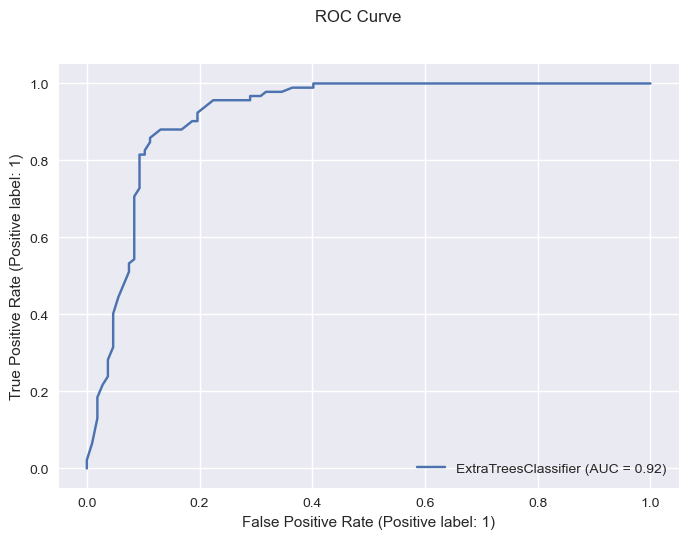

In [67]:
plt.style.use('seaborn')
disp = metrics.plot_roc_curve(Final_Model, X_test, Y_test)
disp.figure_.suptitle("ROC Curve")
plt.show()

# Confusion Matrix

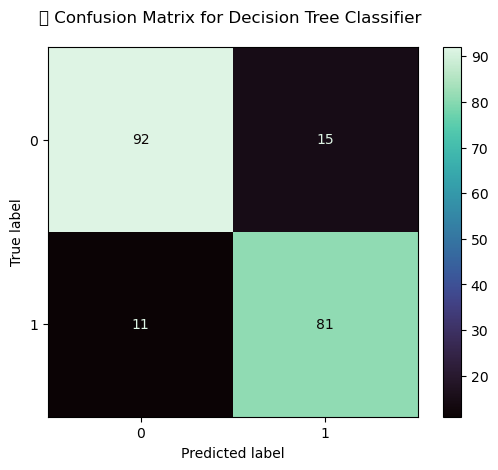

In [68]:
plt.style.use('default')
class_names = df.columns
metrics.plot_confusion_matrix(Classifier, X_test, Y_test, cmap='mako')
plt.title('\t Confusion Matrix for Decision Tree Classifier \n')
plt.show()

#confusion matrix shows the data of correct and false decision